## RQ2 Text Analysis

General plan:
- Follow a similar approach to the Chai-Allah "Data Mining..." paper to create clusters from the data
    - Just use tokenisation first, if 2 big then use lemmatisation
    - for now, just use all words (don't worry about filtering for high frequency words)
    - Use a German version of the word2vec model (see what the baroni one is based on and try to find a German equivalent)
    - use k-means or ward's for the clustering

Steps:
1. Initial Cleaning
2. Language Handling 
3. Tokenisation 
4. Filtering & Lemmatisation (remove stop words, lemmatise, convert to lowercase)
5. Semantic analysis (word2vec)
6. Clustering


In [ ]:
# SETUP

# Import packages
import pandas as pd
import geopandas as gpd
import pickle

import spacy 
from deep_translator import GoogleTranslator
from collections import Counter
from gensim.models import KeyedVectors  # requires scipy version 1.12 (anything newer doesn't work)

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud



### Step 1: Initial Cleaning

General text preparation to get the data in a format which works for translation and for use with spacy. Note that I keep track of trail class and URLS so I can keep track of which class the trail belongs to (RQ3) and so that I can use the URLs to join to the geometries for mapping. 

Decided not to use the comments as there is no guarantee the comments are an expression of someone's perception about the trail/landscape (they might just be saying the trail looks nice from the original posters description, they might be commenting on the directions, etc)

In [2]:
#STEP 1: LOAD & CLEAN

# Load the master CSV from rq2_step1_data_collection
master = pd.read_csv("./processing/master_natflag_version.csv")

# Add ['None'] to any blank rows
# this is necessary for the next step, but then they will be removed later
master.fillna("['None']", inplace=True)

# Create empty dfs for storing trail descriptions and photo captions for classes of interest
raw_text = pd.DataFrame()

# Extract the necessary columns
raw_text["class"] = master["max_class"]
raw_text["natura"] = master["natura"]
raw_text["desc_capt"] = master["description text"] + " " + master["photo_captions"]
raw_text["url_track"] = master["url_track"]

# Create a text cleaning function for the desc_capt column
def text_cleaner(df):
    # Remove all the ['None'] text from each class df
    df["desc_capt"] = df["desc_capt"].str.replace(r"\['None'\]", "", regex=True)
    # Define special characters to be removed
    sp_chars = r"[\[\]'|\\\/+=]"
    for char in sp_chars:
        df["desc_capt"] = df["desc_capt"].str.replace(sp_chars, "", regex=True)
    # This is to address a specific issue in one of the entries (replace with space)
    df["desc_capt"] = df["desc_capt"].str.replace(r"\n", " ", regex=True)
    # Remove any trailing or leading whitespace
    df["desc_capt"] = df["desc_capt"].astype(str).str.strip()
    # Define and drop empty text entries
    ind_to_drop = df[df["desc_capt"] == ""].index  
    df = df.drop(ind_to_drop)
    return df

# Run the text cleaning function on the df
raw_text_clean = text_cleaner(raw_text)

# Check
#raw_text_clean 

### Step 2: Language Handling: Translate to German

As the vast majority of text is in German, I will use this as the base language. I have the option now to either remove anything not in German or to translate it. Although translation is not ideal (maybe some of original meaning is lost/altered), I think this is a better option than just removing the other languages entirely. So here I will tranlsate everything into German. 

As there were some issues with this at first, Ross suggested only translating when there are enough words, for example at least 3 unique tokens. Any language detection algorithm will struggle more when there are only 1 or 2 unique words to go on. This requires some preliminary tokenisation to get the count of unique tokens. **I then discard the text for a trail if it has less than 3 unique tokens**

For translation: deep-translator package: https://pypi.org/project/deep-translator/
- Using Google Translate as it doesn't require API key (DeepL requires API key)


In [3]:
# STEP 2: FILTER OUT SHORT TEXTS

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create a function to tokenise the text for each trail & count the # unique tokens for each trail
def count_unique_tokens(trail_df):
    trail_list = trail_df["desc_capt"]
    unique_token_counts = []
    for trail_text in trail_list:
        doc = nlp(trail_text)
        tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
        unique_tokens = set(tokens)
        unique_token_counts.append(len(unique_tokens))
    return unique_token_counts

# Calculate and add the counts to the df
raw_text_clean["unique_tokens"] = count_unique_tokens(raw_text_clean)

# Filter df to only include rows where unique_tokens >= 3
raw_text_3token = raw_text_clean.loc[(raw_text_clean["unique_tokens"] >= 3)]


DUPLICATE HANDLING

At this point I noticed sometimes there were duplicates in the text. I checked the original master csv and saw that sometimes the same trail is listed twice with different URLs. Sometimes there are slight differences (for example one being classified as road bike, and the other as "unspecified", or having slightly different titles), but the text descriptions &/or captions are the same. So I guess this is an issue with a user uploading the same thing twice or a glitch with Wikiloc.

To handle this, if the texts are the exactly same I remove one of them.

In [5]:
# STEP 2: DUPLICATE TEXT HANDLING AND FINAL TRAIL COUNTS

# Separate trails which intersect with natura from those that don't
raw_text_3token_nat = raw_text_3token[raw_text_3token["natura"]=="natura"]
raw_text_3token_nonnat = raw_text_3token[raw_text_3token["natura"]=="non-natura"]

# Remove duplicates from each subset
raw_text_3token_nat_unq = raw_text_3token_nat.drop_duplicates(subset="desc_capt")
raw_text_3token_nonnat_unq = raw_text_3token_nonnat.drop_duplicates(subset="desc_capt")

# Create per class dfs (for count checks) - NATURA TRAILS
raw_text_3token_nat_unq_c3 = raw_text_3token_nat_unq[raw_text_3token_nat_unq["class"]==3]
raw_text_3token_nat_unq_c4 = raw_text_3token_nat_unq[raw_text_3token_nat_unq["class"]==4]
raw_text_3token_nat_unq_c5 = raw_text_3token_nat_unq[raw_text_3token_nat_unq["class"]==5]
raw_text_3token_nat_unq_c6 = raw_text_3token_nat_unq[raw_text_3token_nat_unq["class"]==6]

# Create per class dfs (for count checks) - NON-NATURA
raw_text_3token_nonnat_unq_c3 = raw_text_3token_nonnat_unq[raw_text_3token_nonnat_unq["class"]==3]
raw_text_3token_nonnat_unq_c4 = raw_text_3token_nonnat_unq[raw_text_3token_nonnat_unq["class"]==4]
raw_text_3token_nonnat_unq_c5 = raw_text_3token_nonnat_unq[raw_text_3token_nonnat_unq["class"]==5]
raw_text_3token_nonnat_unq_c6 = raw_text_3token_nonnat_unq[raw_text_3token_nonnat_unq["class"]==6]

# Calculate totals
count_natura_only = len(raw_text_3token_nat_unq_c3) + len(raw_text_3token_nat_unq_c4) + len(raw_text_3token_nat_unq_c5) + len(raw_text_3token_nat_unq_c6)
count_nonnatura_only = len(raw_text_3token_nonnat_unq_c3) + len(raw_text_3token_nonnat_unq_c4) + len(raw_text_3token_nonnat_unq_c5) + len(raw_text_3token_nonnat_unq_c6)

# Print out all counts
print(f"Class 3 trails (Natura only): {len(raw_text_3token_nat_unq_c3)}")
print(f"Class 4 trails (Natura only): {len(raw_text_3token_nat_unq_c4)}")
print(f"Class 5 trails (Natura only): {len(raw_text_3token_nat_unq_c5)}")
print(f"Class 6 trails (Natura only): {len(raw_text_3token_nat_unq_c6)}")
print(f"  Total trails (Natura only): {count_natura_only}")
print("----------------------------------")
print(f" Class 3 trails (Non-Natura): {len(raw_text_3token_nonnat_unq_c3)}")
print(f" Class 4 trails (Non-Natura): {len(raw_text_3token_nonnat_unq_c4)}")
print(f" Class 5 trails (Non-Natura): {len(raw_text_3token_nonnat_unq_c5)}")
print(f" Class 6 trails (Non-Natura): {len(raw_text_3token_nonnat_unq_c6)}")
print(f"   Total trails (Non-Natura): {count_nonnatura_only}")
print("----------------------------------")
print(f"        Class 3 trails (ALL): {len(raw_text_3token_nat_unq_c3) + len(raw_text_3token_nonnat_unq_c3)}")
print(f"        Class 4 trails (ALL): {len(raw_text_3token_nat_unq_c4) + len(raw_text_3token_nonnat_unq_c4)}")
print(f"        Class 5 trails (ALL): {len(raw_text_3token_nat_unq_c5) + len(raw_text_3token_nonnat_unq_c5)}")
print(f"        Class 6 trails (ALL): {len(raw_text_3token_nat_unq_c6) + len(raw_text_3token_nonnat_unq_c6)}")
print(f"          Total trails (ALL): {count_natura_only + count_nonnatura_only}")



Class 3 trails (Natura only): 67
Class 4 trails (Natura only): 99
Class 5 trails (Natura only): 189
Class 6 trails (Natura only): 1324
  Total trails (Natura only): 1679
----------------------------------
 Class 3 trails (Non-Natura): 100
 Class 4 trails (Non-Natura): 131
 Class 5 trails (Non-Natura): 168
 Class 6 trails (Non-Natura): 662
   Total trails (Non-Natura): 1061
----------------------------------
        Class 3 trails (ALL): 167
        Class 4 trails (ALL): 230
        Class 5 trails (ALL): 357
        Class 6 trails (ALL): 1986
          Total trails (ALL): 2740


**TRANSLATION**

For the next step I originally tried using langdetect to detect whether the text was already in German and then passing anything not in German to deep_translator for the actual translation. I found this didn't always work that well and had issues with it failing to translate or translating when it didn't need to. I therefore tried an alternate approach where deep_translator is used for everything (the auto language detection is used and then everything that is not already German is translated to German; text already in German is skipped).

I compared both approaches for a subset of the data (Bremen, Niedersachsen and Saxony-Anhalt trails - 289 trails total) and found that the success rate was better for the deep_translator only approach, so I have continued with this approach. See details below.

| Category                         | Combo Lang Detect & Deep Translator | Deep Translator Only |
| -------------------------------- | ----------------------------------- | -------------------- |
| DE correctly recognised          | 201                                 | 211                  |
| successful translation           | 33	                                 | 48                   |
| mixed lang - unchanged	       | 5	                                 | 3                    |
| mixed lang - some issues	       | 9	                                 | 6                    |
| unneeded translation	           | 6	                                 | 4                    |
| failed to translate	           | 14	                                 | 6                    |
| incorrect translation	           | 7	                                 | 4                    |
| unneeded & incorrect translation | 14 	                             | 7                    |
| Total	                           | 289	                             | 289                  |
| Success Rate	                   | 80.97%                              | 89.62%               |



Also for the next step I ran into problems where the translation would fail because there were too many characters for an individual trail (the error message was: Text length need to be between 0 and 5000 character). I've therefore added an additional step here to basically cut off anything after 5000 characters. In case this results in a partial word at the end, I also remove the last word/partial word to ensure that there isn't an incomplete token later (I split the text from the right according to where the first white space is and then remove everything after that white space).

First I run a count to check how many trails would be affected by the truncating - then I truncate the text and check again to make sure there are no trails with >5000 characters.


In [6]:
# STEP 2: COUNT >5000

# Create function for counting trails with more than 5000 characters
def counter_5000(trail_list):
    count_5000 = 0
    for trail_text in trail_list:
        if len(trail_text) > 5000:
            count_5000 += 1
    return count_5000 

# Check for trails with >5000 characters 
print(f"    Trails with >5000 characters (Natura): {counter_5000(raw_text_3token_nat_unq["desc_capt"])}")
print(f"Trails with >5000 characters (Non-Natura): {counter_5000(raw_text_3token_nonnat_unq["desc_capt"])}")


    Trails with >5000 characters (Natura): 1
Trails with >5000 characters (Non-Natura): 1


In [7]:
# STEP 2: TRUNCATE >5000

# Set as copy to avoid SettingWithCopyWarning
raw_text_3token_nat_unq = raw_text_3token_nat_unq.copy()
raw_text_3token_nonnat_unq = raw_text_3token_nonnat_unq.copy()

# Create function to truncate text with >5000 characters
# Also remove the last word after the text is truncated in case it's only a partial word
def trunc_5000(trail_df):
    trail_list = trail_df["desc_capt"]
    less_than_5000 = []
    for trail_text in trail_list:
        if len(trail_text) > 5000:
            trail_text_trunc = trail_text[:5000]
            trail_text_trunc = trail_text_trunc.rsplit(' ', 1)[0]
            less_than_5000.append(trail_text_trunc)
        else:
            less_than_5000.append(trail_text)
    return less_than_5000

# Run the truncate function 
raw_text_3token_nat_unq["desc_capt"] = trunc_5000(raw_text_3token_nat_unq)
raw_text_3token_nonnat_unq["desc_capt"] = trunc_5000(raw_text_3token_nonnat_unq)

# Check for trails with >5000 characters 
print(f"    Trails with >5000 characters (Natura): {counter_5000(raw_text_3token_nat_unq["desc_capt"])}")
print(f"Trails with >5000 characters (Non-Natura): {counter_5000(raw_text_3token_nonnat_unq["desc_capt"])}")


    Trails with >5000 characters (Natura): 0
Trails with >5000 characters (Non-Natura): 0


In [12]:
# STEP 2: TRANSLATE TO GERMAN (RUN ONCE)
# TAKES ABOUT 15-20 MIN

# Create a function for translating the text to German
# Use deep translator to automatically detect language and translate 
# If German is detected it will skip the entry (ie. it will not try to translate)
def de_translate(trail_df):
    trail_list = trail_df["desc_capt"]
    translated_list = []
    translated_count = 0
    skipped_count = 0
    for trail_text in trail_list:
        translated = GoogleTranslator(source='auto', target='de').translate(text=trail_text)
        translated_list.append(translated)
        # Check if translation changed anything
        if translated.strip() == trail_text.strip():
            skipped_count += 1
        else:
            translated_count += 1
    return translated_list, translated_count, skipped_count

# Run the function on each of the class lists (store the 3 outputs as 3 variables)
translated_list_nat, translated_count_nat, skipped_count_nat = de_translate(raw_text_3token_nat_unq)
translated_list_nonnat, translated_count_nonnat, skipped_count_nonnat = de_translate(raw_text_3token_nonnat_unq)

# Add translation to main dfs
raw_text_3token_nat_unq["desc_capt_de"] = translated_list_nat
raw_text_3token_nonnat_unq["desc_capt_de"] = translated_list_nonnat

# Calculate percentages
per_trans_nat = round(((translated_count_nat/(translated_count_nat + skipped_count_nat))*100),2)
per_trans_nonnat = round(((translated_count_nonnat/(translated_count_nonnat + skipped_count_nonnat))*100),2)
per_trans_all = round((((translated_count_nat + translated_count_nonnat)/(translated_count_nat + translated_count_nonnat + skipped_count_nat + skipped_count_nonnat))*100),2)

# Check results 
print(f"  Total Translated (Natura): {translated_count_nat}")
print(f"   Total Unchanged (Natura): {skipped_count_nat}")
print(f"Percent translated (Natura): {per_trans_nat}")
print("----------------------------")
print(f"  Total Translated (Non-Natura): {translated_count_nonnat}")
print(f"   Total Unchanged (Non-Natura): {skipped_count_nonnat}")
print(f"Percent translated (Non-Natura): {per_trans_nonnat}")
print("----------------------------")
print(f"  Total Translated (ALL): {translated_count_nat + translated_count_nonnat}")
print(f"   Total Unchanged (ALL): {skipped_count_nat + skipped_count_nonnat}")
print(f"Percent translated (ALL): {per_trans_all}")


  Total Translated (Natura): 691
   Total Unchanged (Natura): 988
Percent translated (Natura): 41.16
----------------------------
  Total Translated (Non-Natura): 404
   Total Unchanged (Non-Natura): 657
Percent translated (Non-Natura): 38.08
----------------------------
  Total Translated (ALL): 1095
   Total Unchanged (ALL): 1645
Percent translated (ALL): 39.96


**IMPORTANT** After running through the whole process several times, I noticed the translation step above does not always produce the exact same results. 

Using a quick comparison tool in Notepad++ (https://stackoverflow.com/questions/33523362/how-to-compare-two-csv-files-in-windows) I found that the translations can vary slightly. For example, for this trail with the original language in Dutch (https://www.wikiloc.com/hiking-trails/wichlinghausen-bielefeld-26049058) the word for boss/owner was translated to "Eigentürmer" in one run of the translation and "Besitzer" in a second run. Unfortunately this seems to be a flaw of the deep_translator and/or the Google translate service and I could not find a way to ensure that the outputs are always the same. 

To allow for reproducible results I therefore output the translations from the step above as a using pickle dump (for my own use going forward) and also as a CSV which I will include in the repo (in the "other" folder.)

In [13]:
# STEP 2: SAVE TRANSLATED TEXT

pickle.dump(raw_text_3token_nat_unq, open("./processing/raw_text_de_natura_only.p", "wb"))
pickle.dump(raw_text_3token_nonnat_unq, open("./processing/raw_text_de_nonnatura.p", "wb"))

# Save as CSV for translation reproducibility
raw_text_3token_nat_unq.to_csv("./processing/translated_text_natura.csv", index = False, encoding="utf-8-sig")
raw_text_3token_nonnat_unq.to_csv("./processing/translated_text_nonnatura.csv", index = False, encoding="utf-8-sig")


In [14]:
# STEP 2: LOAD TRANSLATED TEXT

raw_text_3token_nat_unq = pickle.load(open("./processing/raw_text_de_natura_only.p", "rb"))
raw_text_3token_nonnat_unq = pickle.load(open("./processing/raw_text_de_nonnatura.p", "rb"))


### Step 3: Tokenisation 

German spacy model options: https://spacy.io/models/de 

Installed so far:
de_core_news_sm 
de_core_news_lg

I tested both these small and large models. When only using the tokens it doesn't make a difference - the large model only improves the result if using the lemmas. As I decided not to use the lemmas, I will stick with the small model. 

Note: I split everything into various lists at this stage to help with exploring class 3 and 6 results separately for RQ3.

In [15]:
# STEP 3: CONVERT TO LISTS

# Create per class lists of TRANSLATED text for Natura only
raw_text_de_nat_c3 = raw_text_3token_nat_unq.loc[raw_text_3token_nat_unq["class"] == 3, "desc_capt_de"].tolist()
raw_text_de_nat_c45 = raw_text_3token_nat_unq.loc[raw_text_3token_nat_unq["class"].isin([4, 5]), "desc_capt_de"].tolist()
raw_text_de_nat_c6 = raw_text_3token_nat_unq.loc[raw_text_3token_nat_unq["class"] == 6, "desc_capt_de"].tolist()

# Create per class lists of TRANSLATED text for Non-Natura trails
raw_text_de_nonnat_c3 = raw_text_3token_nonnat_unq.loc[raw_text_3token_nonnat_unq["class"] == 3, "desc_capt_de"].tolist()
raw_text_de_nonnat_c45 = raw_text_3token_nonnat_unq.loc[raw_text_3token_nonnat_unq["class"].isin([4, 5]), "desc_capt_de"].tolist()
raw_text_de_nonnat_c6 = raw_text_3token_nonnat_unq.loc[raw_text_3token_nonnat_unq["class"] == 6, "desc_capt_de"].tolist()


In [16]:
# STEP 3: TOKENISATION

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create a function for tokenising each input list
def tokeniser(trail_list):
    doc = []
    for string in trail_list:
        doc.extend(nlp(string))
    return doc

# Run the tokeniser for each class list for Natura trails
doc_nat_c3 = tokeniser(raw_text_de_nat_c3)
doc_nat_c45 = tokeniser(raw_text_de_nat_c45)
doc_nat_c6 = tokeniser(raw_text_de_nat_c6)

# Run the tokeniser for each class list for Non-Natura trails
doc_nonnat_c3 = tokeniser(raw_text_de_nonnat_c3)
doc_nonnat_c45 = tokeniser(raw_text_de_nonnat_c45)
doc_nonnat_c6 = tokeniser(raw_text_de_nonnat_c6)


I added this alternative tokenisation approach below for creating the map series (trails for each cluster). In this approach I keep everything together in a dataframe so that the tokens are still connected with their unique identifier (i.e. their URL). I don't perform any filtering/cleaning on this version as I only use it for the maps, and filtering is not needed -- as a result, this tokenised_df output is not intended for any other use (i.e. it is not for creating the clusters or any other analysis).

ALSO: this extra step is only needed for the Natura trails.

In [17]:
# STEP 3: TOKENISATION EXTRA (FOR MAPPING TOKENS LATER - NATURA ONLY)

# Create a function which tokenises the desc_capt_de column of the original df and returns
# a df including the track url and the tokens (needed for map figures later)
def tokenise_per_trail_df(df, text_column="desc_capt_de", id_column="url_track"):
    data = []
    for index, row in df.iterrows():
        url = row[id_column]
        text = row[text_column]
        tokens = [token.text for token in nlp(text)]
        data.append({id_column: url, "tokens": tokens})
    return pd.DataFrame(data)

# Run the function on the df with all classes together (NATURA only)
tokenised_nat_df = tokenise_per_trail_df(raw_text_3token_nat_unq)

# Save the outputs
pickle.dump(tokenised_nat_df, open("./processing/tokenised_nat_df.p", "wb"))


### Step 4: Filtering 

Remove stop words, punctuation & numbers from the token list. Also, convert all to lower-case.

Details:
- remove stop words (is_stop)
    - I added some custom stop words like "Foto", "Waypoint" and "null" (and similar versions) as this is just placeholder text
- remove puncutation (is_punct)
- remove numbers (is_digit & like_num)
- remove spaces (is_space)
- remove urls (like URL)
- only keep tokens that are made up entirely of alphabetic chacacters (is_alpha) - this gets rid of things like "hwn01" - doesn't effect the final clustering much as these are not in the word2vec model anyways


In [19]:
# STEP 4: STOP WORDS ETC

# Create a set of stop word to add into the built-in ones (note they are only stored as lower-case versions)
extra_stop_words = {"foto", "fotos", "photo", "photos", "null", "waypoint"}

# Combine my extra stop words with the ones from spacy
full_stop_words = extra_stop_words.union(nlp.Defaults.stop_words)

# Create a cleaning function for filtering and converting to lowercase
# also make sure to compare lower-case versions of the tokens to the stop words
# OPTION: use token.lemma_.lower() (instead of token.text.lower()) to extract the lemma for the final tokens
def token_cleaner(token_doc):
    return [
        token.text.lower() for token in token_doc
        if token.is_alpha 
        and token.text.lower() not in full_stop_words
        and not (token.is_punct or token.is_digit or 
                 token.like_num or token.is_space or token.like_url)
    ]

# Run the filter function for each class list for Natura trails
filtered_tokens_nat_c3 = token_cleaner(doc_nat_c3)
filtered_tokens_nat_c45 = token_cleaner(doc_nat_c45)
filtered_tokens_nat_c6 = token_cleaner(doc_nat_c6)

# Run the filter function for each class list for Non-Natura trails
filtered_tokens_nonnat_c3 = token_cleaner(doc_nonnat_c3)
filtered_tokens_nonnat_c45 = token_cleaner(doc_nonnat_c45)
filtered_tokens_nonnat_c6 = token_cleaner(doc_nonnat_c6)
   

In [20]:
# STEP 4: SAVE ALL FINALISED TOKENS (C3 & C6 FOR RQ3)

# Natura trails only 
pickle.dump(filtered_tokens_nat_c3, open("./processing/final_tokens_nat_c3.p", "wb"))
pickle.dump(filtered_tokens_nat_c45, open("./processing/final_tokens_nat_c45.p", "wb"))
pickle.dump(filtered_tokens_nat_c6, open("./processing/final_tokens_nat_c6.p", "wb"))

# Non-Natura trails only 
pickle.dump(filtered_tokens_nonnat_c3, open("./processing/final_tokens_nonnat_c3.p", "wb"))
pickle.dump(filtered_tokens_nonnat_c45, open("./processing/final_tokens_nonnat_c45.p", "wb"))
pickle.dump(filtered_tokens_nonnat_c6, open("./processing/final_tokens_nonnat_c6.p", "wb"))


In [21]:
# STEP 4: LOAD FINALISED TOKENS - ONLY NATURA ONES

# From this point on, I only work with the tokens for Natura trails
filtered_tokens_nat_c3 = pickle.load(open("./processing/final_tokens_nat_c3.p", "rb"))
filtered_tokens_nat_c45 = pickle.load(open("./processing/final_tokens_nat_c45.p", "rb"))
filtered_tokens_nat_c6 = pickle.load(open("./processing/final_tokens_nat_c6.p", "rb"))


After this point, I don't need to keep the tokens separated by class, so I simply merge them into one big list.

In [22]:
# STEP 4: MERGE CLASSES

filtered_tokens_nat = filtered_tokens_nat_c3 + filtered_tokens_nat_c45 + filtered_tokens_nat_c6


In [23]:
# STEP 4: CHECKING SOME RESULTS

# Count the frequency of each token
word_freq = Counter(filtered_tokens_nat)

# Check the top 20 most common tokens
common_words = word_freq.most_common(20)
common_words


[('weg', 185),
 ('blick', 129),
 ('aussicht', 105),
 ('parkplatz', 98),
 ('schöne', 91),
 ('wanderung', 88),
 ('entlang', 84),
 ('burg', 83),
 ('wald', 81),
 ('m', 76),
 ('rechts', 75),
 ('punkt', 74),
 ('hwn', 68),
 ('route', 66),
 ('km', 66),
 ('wegpunkt', 66),
 ('start', 65),
 ('richtung', 63),
 ('schöner', 63),
 ('links', 63)]

Side note: HWN stands for Harzer Wandernadel which is a hiking badge system for the Harz mountains https://en.wikipedia.org/wiki/Harzer_Wandernadel

### STEP 5: Semantic analysis (word2vec)

Using the de_wiki word2vec model from https://sites.google.com/site/fritzgntr/software-resources/semantic_spaces because it is the closest one to the baroni model used in the Chai-allah paper but for German. 

The semantic spaces are provided in .rda format for R but can be export as a txt for use outside R using the following commands (in R). NOTE: I had to adjust from the instruction on the source website as it didn't account for use in gensim, which then meant I had problems with quotes and separators.

 load("C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.rda")

 write.table(de_wiki, file = "C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.txt", row.names = TRUE, col.names = FALSE, quote = FALSE, sep = " ")
 

 Some useful notes/resources:
 - "a word embedding refers to a vector representation of a particular word or phrase in a multidimensional space" (Generally this website is helpful: https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/)
 - https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
 - https://medium.com/@denis.arvizu/text-clustering-using-word2vec-a89fbd9b9d0f

In [18]:
# STEP 5: MODEL PREP (RUN ONCE!)

# First I need to adjust the encoding and add the header information required by gensim
# Then I can save it in gensim format for easier use

# Count rows and vector size for header info
with open("./word2vec/de_wiki.txt", encoding="ISO-8859-1") as f:
    lines = f.readlines()

num_words = len(lines)
vector_size = len(lines[0].split()) - 1

# Write in utf-8 with header info
with open("./word2vec/de_wiki_utf8_header.txt", "w", encoding="utf-8") as f:
    f.write(f"{num_words} {vector_size}\n")
    f.writelines(lines)

# Load model (from new txt file) with gensim
model = KeyedVectors.load_word2vec_format("./word2vec/de_wiki_utf8_header.txt", binary=False)

# Save the model in optimised gensim format (this will make the loading faster for next time)
model.save("./word2vec/de_wiki_final.model")


In [24]:
# STEP 5: CHECKING MODEL

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Which tokens are known versus which are missing in model?
known_tokens = [token for token in filtered_tokens_nat if token in model]
unique_known_tokens = set(known_tokens)
unique_known_count = len(unique_known_tokens)

missing_tokens = [token for token in filtered_tokens_nat if token not in model]
unique_missing_tokens = set(missing_tokens)
unique_missing_count = len(unique_missing_tokens)

# Print results
print("Total known tokens", len(known_tokens))
print("Total missing tokens", len(missing_tokens))
print("Percentage absolute missing:", round((len(missing_tokens)/(len(known_tokens)+len(missing_tokens)) *100), 2))
print("-----")
print("Unique known tokens:", unique_known_count)
print("Unique missing tokens:", unique_missing_count)
print("Percentage unique missing:", round((unique_missing_count/(unique_known_count+unique_missing_count)*100), 2))
print("-----")
print("Missing tokens:", unique_missing_tokens)


Total known tokens 16342
Total missing tokens 3854
Percentage absolute missing: 19.08
-----
Unique known tokens: 6242
Unique missing tokens: 2871
Percentage unique missing: 31.5
-----
Missing tokens: {'spitzsteinschlüchte', 'hexenstiegs', 'pizful', 'wederath', 'chartaque', 'bienenschmidt', 'avenhausen', 'grafel', 'mucherwiesenbachs', 'lingesetalsper', 'ndian', 'neuweg', 'diebskeller', 'zeughausstrasse', 'glockenfoto', 'erkensruhr', 'kermeterufer', 'krausberg', 'dammkarhütte', 'sanitärbrambel', 'kuttbachhöle', 'gimmeldinger', 'bollerwienquelle', 'cascadilla', 'bandweg', 'felsöffnung', 'adlerteich', 'flussfoto', 'meckelsen', 'exbummel', 'emblemático', 'bajans', 'skiheim', 'pasages', 'prießnitzgrundweg', 'titisiesee', 'steinhauerweg', 'trailhead', 'kastanienplatz', 'rimba', 'dreitälerblick', 'adamsmühle', 'hexenlochmühle', 'winnerath', 'oberseiffenbach', 'hasselbrack', 'gladitschturm', 'hochthürmen', 'hollest', 'sinkhaller', 'buntenbock', 'trifelsblick', 'steinhalskopf', 'hohlestein', 'ap

In [25]:
# STEP 5: CONVERT TOKENS TO VECTORS (CREATE WORD EMBEDDINGS)

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Create empty list to store vectors
vectors = []

# Create empty list to store valid tokens (i.e. tokens which are present in the model)
valid_tokens = []

# Store the vectors for each token
for token in filtered_tokens_nat:
    if token in model:
        vector = model[token]
        vectors.append(vector)
        valid_tokens.append(token)


**NOTE**
I thought I had to change the code above so that the tokens were grouped together by their trail (so when determining the vector it takes the context of the words in the correct trail description) - BUT I think this is actually not the way the model works: the model uses a context window of 5 when training the model to create the vectors - but once the vectors are created they are just applied on a word-by-word basis (i.e. bag of words model). 

In [26]:
# STEP 5: SAVE VECTOR & VALID TOKEN OUTPUTS 

pickle.dump(vectors, open("./processing/vectors.p", "wb"))
pickle.dump(valid_tokens, open("./processing/valid_tokens.p", "wb"))


In [27]:
# STEP 5: LOAD VECTOR & VALID TOKEN OUTPUTS 

vectors = pickle.load(open("./processing/vectors.p", "rb"))
valid_tokens = pickle.load(open("./processing/valid_tokens.p", "rb"))


### Step 6: Clustering

For the clustering I use kmeans on the cosine similarity/distance of the vectors. The main steps are:
1) Prepare vectors (normalise & reduce dimensions)
2) Establish k (number of clusters)
3) Run kmeans and label tokens
4) Create visuals

Some resources:
- GEO881 Assignment 1, Part 2 (kmeans classification - but in R)
- https://www.w3schools.com/python/python_ml_k-means.asp
- https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b


**STEP 6.1: Prepare vectors (normalise & reduce dimensions)**

The kmeans algorithm only accepts Euclidean or Manhattan distance - but for this type of clustering the cosine distance is required (to cluster based on words with similar semantic meanings). I found the following resources which indicate that normalising the vectors is a way to "convert" to cosine similarity/distance for kmeans:

- https://medium.com/ai-for-real/relationship-between-cosine-similarity-and-euclidean-distance-7e283a277dff
- https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python
- https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans 

Basically when you normalise the vectors and input them to kmeans (which expects Euclidean distance) the behaviour is like inputing cosine distances - which is what we want. 

Normalising the vectors still outputs vectors with the same number of dimensions. It sets the magnitude of the vector (the length) to 1 for all vectors, and it preserves the angle of the vector (which is the important part for clustering based on semantic similarity). In this way the comparison between vectors is just about the angle (semantics) and not about the magnitude (which can be arbitrary).

**UPDATE** 
After running through the whole clustering process several times, I noticed the outputs were a bit sensitive to the initial state (random state) for the kmeans clustering. While there would almost always be clusters for aesthetics (words like schöne), nature (words like wald, see), heritage (words like burg, schloss), and English words, and there were often clusters for placenames, words about the view (blick, aussicht), the composition of the clusters varied and there were blurred boundaries between some of the clusters. For example sometimes the nature and heritage clusters would blend a bit, or the heritage and placenames. 

I decided to try to two approaches to help bring more stabiliy to the clustering:
1) Use PCA to reduce the number of dimensions - this could indirectly help by reducing some of the noise. I experimented by reducing the dimensions to retain either 90% or 95% of the variance. For both, the general theme of the clusters are similar to without reducing the dimensions, but I noticed for the 90% version the cluster composition seemed to change less when I changed the random state - so I selected the 90% reduced version.
2) Using a higher value for n_init in the kmeans algorithm to run with more seeds (the output then takes the best output in terms of the inertia / within cluster sum of squares). By default it runs on "auto" but I forced it to run more iterations with n_init=50

In [191]:
# STEP 6.1: NORMALISE & REDUCE DIMENSIONS

# Normalising the vectors means they will behave like cosine distance when input to kmeans
normalised_vectors = normalize(vectors)

# Reduce the dimensions of the vectors while retaining 90% of the variance
pca_90 = PCA(n_components=0.90)
reduced_90_vectors = pca_90.fit_transform(normalised_vectors)

# Check the reduction in dimensions
print(f"Original dimensions: {normalised_vectors.shape[1]}")
print(f"Dimensions retaining 90% of variance: {reduced_90_vectors.shape[1]}")


Original dimensions: 400
Dimensions retaining 90% of variance: 275


**STEP 6.1: Prepare vectors (normalise & reduce dimensions)**

I use the elbow plot method here to estimate an appropriate number of clusters.

Note I got the following error message when running this originally: *UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.* To resolve this I edited the **system environment variables** using the instructions in the first answer here: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

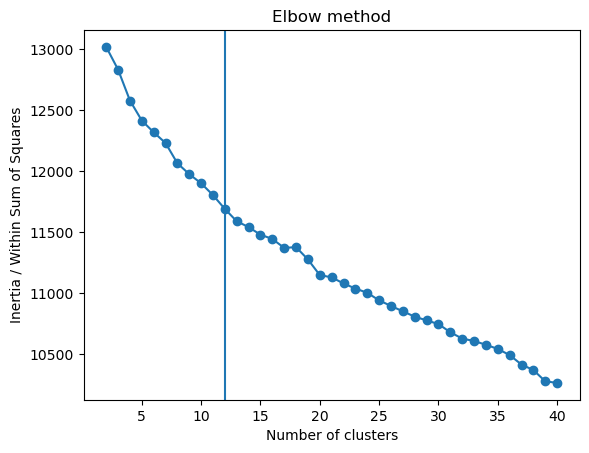

In [192]:
# STEP 6.2: DETERMINE NUMBER OF CLUSTERS

# Create empty list for intertias (within cluster sum of squares)
inertias = []

# Test kmeans intertias/within ss for 2-40 clusters
# Random state needed for reproducible results
for k in range(2,41):
  kmeans = KMeans(n_clusters=k, max_iter=200, random_state=67)
  kmeans.fit(reduced_90_vectors) 
  inertias.append(kmeans.inertia_)

# Generate the elbow plot
plt.plot(range(2,41), inertias, marker='o')
plt.axvline(x = 12) # Guiding line for selected number of clusters
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Within Sum of Squares')
plt.show() 


As the elbow plot above is a bit tricky to interpret, I experimented with a range of k between 10 to 14.  Heritage and placename clusters often merged together for 10 clusters and for 14 clusters there was often just more clusters related to trails/placenames (i.e. there was just more separation between the non-CES themes which I'm not as interested in). So 12 clusters seemed to be a bit of a sweet spot

In [281]:
# STEP 6.3: GENERATE CLUSTERS WITH KMEANS

# Define number of clusters based on elbow plot
n_clusters = 12

# Generate kmeans clusters and labels 
# n_init=50 seems to help make the clusters more stable
# Random state needed for reproducible clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=77)
kmeans.fit(reduced_90_vectors)
labels = kmeans.labels_

# Create a df with the cluster number for each token contained in the model
token_cluster_all = pd.DataFrame({"token": valid_tokens, "cluster": labels})

# Check
token_cluster_all


,token,cluster
0,breite,3
1,forstwege,1
2,pfade,1
3,halber,3
4,strecke,1
...,...,...
16337,marienthal,5
16338,höhe,3
16339,sonne,6
16340,fast,3


In [282]:
# STEP 6.3: SAVE OUTPUTS FOR RQ3

pickle.dump(token_cluster_all, open("./processing/token_cluster_all.p", "wb"))

**STEP 6.4: Create Visuals**

- word clouds (top 10 tokens per cluster)
- bar chart for number of tokens per cluster
- bar charts for frequency of top 10 tokens per cluster
- mini maps which link clusters (tokens in cluster) to their trail geometries

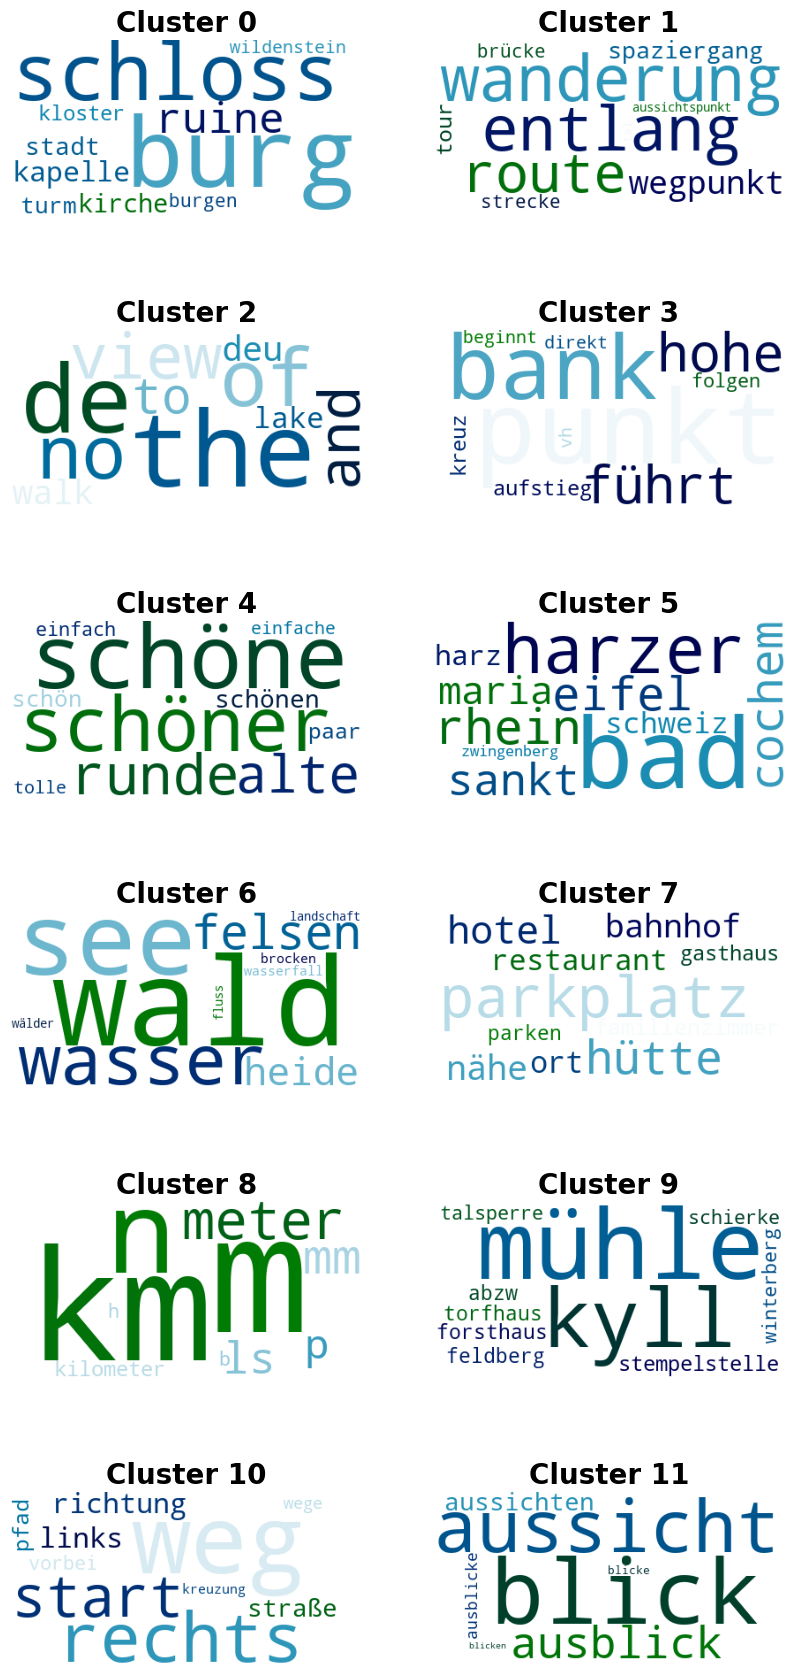

In [283]:
# STEP 6.4: WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc = []

# For each cluster number use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 10 TOKENS IN EACH CLUSTER
for clus_num in range(12):  
    freqs = get_cluster_freq(token_cluster_all, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc.append(wc)

# Create custom titles
all_titles = ["Cluster 0", "Cluster 1", 
              "Cluster 2",  "Cluster 3", 
              "Cluster 4", "Cluster 5", 
              "Cluster 6", "Cluster 7", 
              "Cluster 8", "Cluster 9",
              "Cluster 10", "Cluster 11"]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 22))

# Allows to iterate in 1 dimension
axes = axes.flatten()

# Iterate through word clouds and titles to plot
for i, (wc, title) in enumerate(zip(all_wc, all_titles)):
    axes[i].imshow(wc)
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=20, fontweight="bold")

# Save the figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq2_word_clouds.png', bbox_inches='tight')

# Display final figure
plt.show()



In [284]:
# STEP 6.4: TOTAL TOKENS

# Calculate the total number of tokens across all clusters
total_token_count = len(token_cluster_all)

print(f"Total Tokens: {total_token_count}")

Total Tokens: 16342


In [285]:
# STEP 6.4: CLUSTER COMPARISON

# Create df for storing total number of tokens for each cluster
cluster_counts_df = pd.DataFrame()

# Create column for the cluster name (UPDATE LATER)
cluster_counts_df["cluster_name"] = ["Cluster 0", "Cluster 1", "Cluster 2",  "Cluster 3", 
                                     "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", 
                                     "Cluster 8", "Cluster 9", "Cluster 10", "Cluster 11"]

# Create empty list for storing counts per cluster
token_counts = []

# Iterate through each cluster to count the number of tokens & append to list
for clus_num in range(12):
    count = len(token_cluster_all[token_cluster_all["cluster"] == clus_num])
    token_counts.append(count)

# Add token counts to df
cluster_counts_df["token_count"] = token_counts

# Check
#cluster_token_counts_df

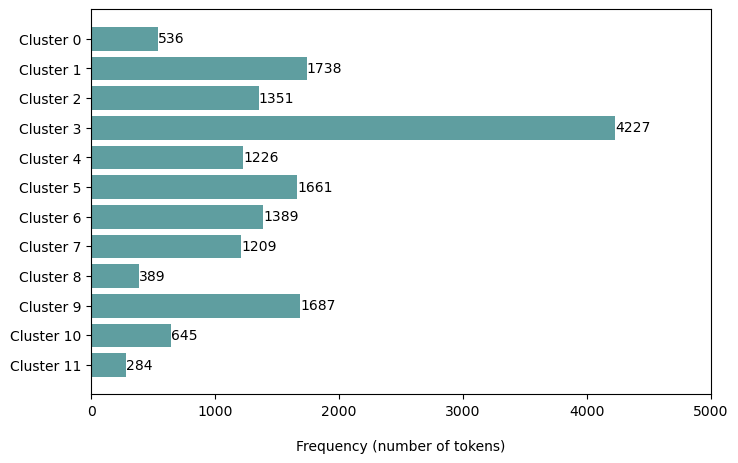

In [286]:
# STEP 6.4: CLUSTER COMPARISON
# Create horizontal bar chart for token counts per cluster

# Set up fig and ax
fig, ax = plt.subplots(figsize=(8,5))

# Set up horizontal bar chart
bar_chart = ax.barh(cluster_counts_df["cluster_name"], 
                    cluster_counts_df["token_count"],
                    color = "CadetBlue")

# Customise yaxis order, set up labels and extend xlim to fit value labels
ax.invert_yaxis()  
ax.set_xlabel('Frequency (number of tokens)', labelpad=15)
ax.bar_label(bar_chart)
ax.set_xlim(right=5000) 

# Save the figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq2_cluster_counts.png', bbox_inches='tight')

# Show plot
plt.show()

In [287]:
# STEP 6.4: CLUSTER MEMBERSHIP - TOKEN COMPARISON

# Create function for getting the frequenies for each token (using another function from above)
def cluster_token_freqs(df, clus_range):
    clus_freqs = []
    for clus_num in clus_range:
        clus_freq = get_cluster_freq(df, clus_num)
        clus_freqs.append(clus_freq)
    return clus_freqs

# Run the cluster_token_freqs function for each cluster
clus0, clus1, clus2, clus3, clus4, clus5, \
    clus6, clus7, clus8, clus9, clus10,   \
        clus11, clus12, clus13 = cluster_token_freqs(token_cluster_all, range(14))

# Create function for generating dfs with top 10 tokens from each cluster 
def top10_tokens(counter_obj):
    top10_df = pd.DataFrame.from_records(counter_obj.most_common(10), columns=['token','count'])
    return top10_df

# Use function for creating dfs per class and cluster
clus0_top10_df = top10_tokens(clus0)
clus1_top10_df = top10_tokens(clus1)
clus2_top10_df = top10_tokens(clus2)
clus3_top10_df = top10_tokens(clus3)
clus4_top10_df = top10_tokens(clus4)
clus5_top10_df = top10_tokens(clus5)
clus6_top10_df = top10_tokens(clus6)
clus7_top10_df = top10_tokens(clus7)
clus8_top10_df = top10_tokens(clus8)
clus9_top10_df = top10_tokens(clus9)
clus10_top10_df = top10_tokens(clus10)
clus11_top10_df = top10_tokens(clus11)
clus12_top10_df = top10_tokens(clus12)
clus13_top10_df = top10_tokens(clus13)

# Check
#clus5_top10_df

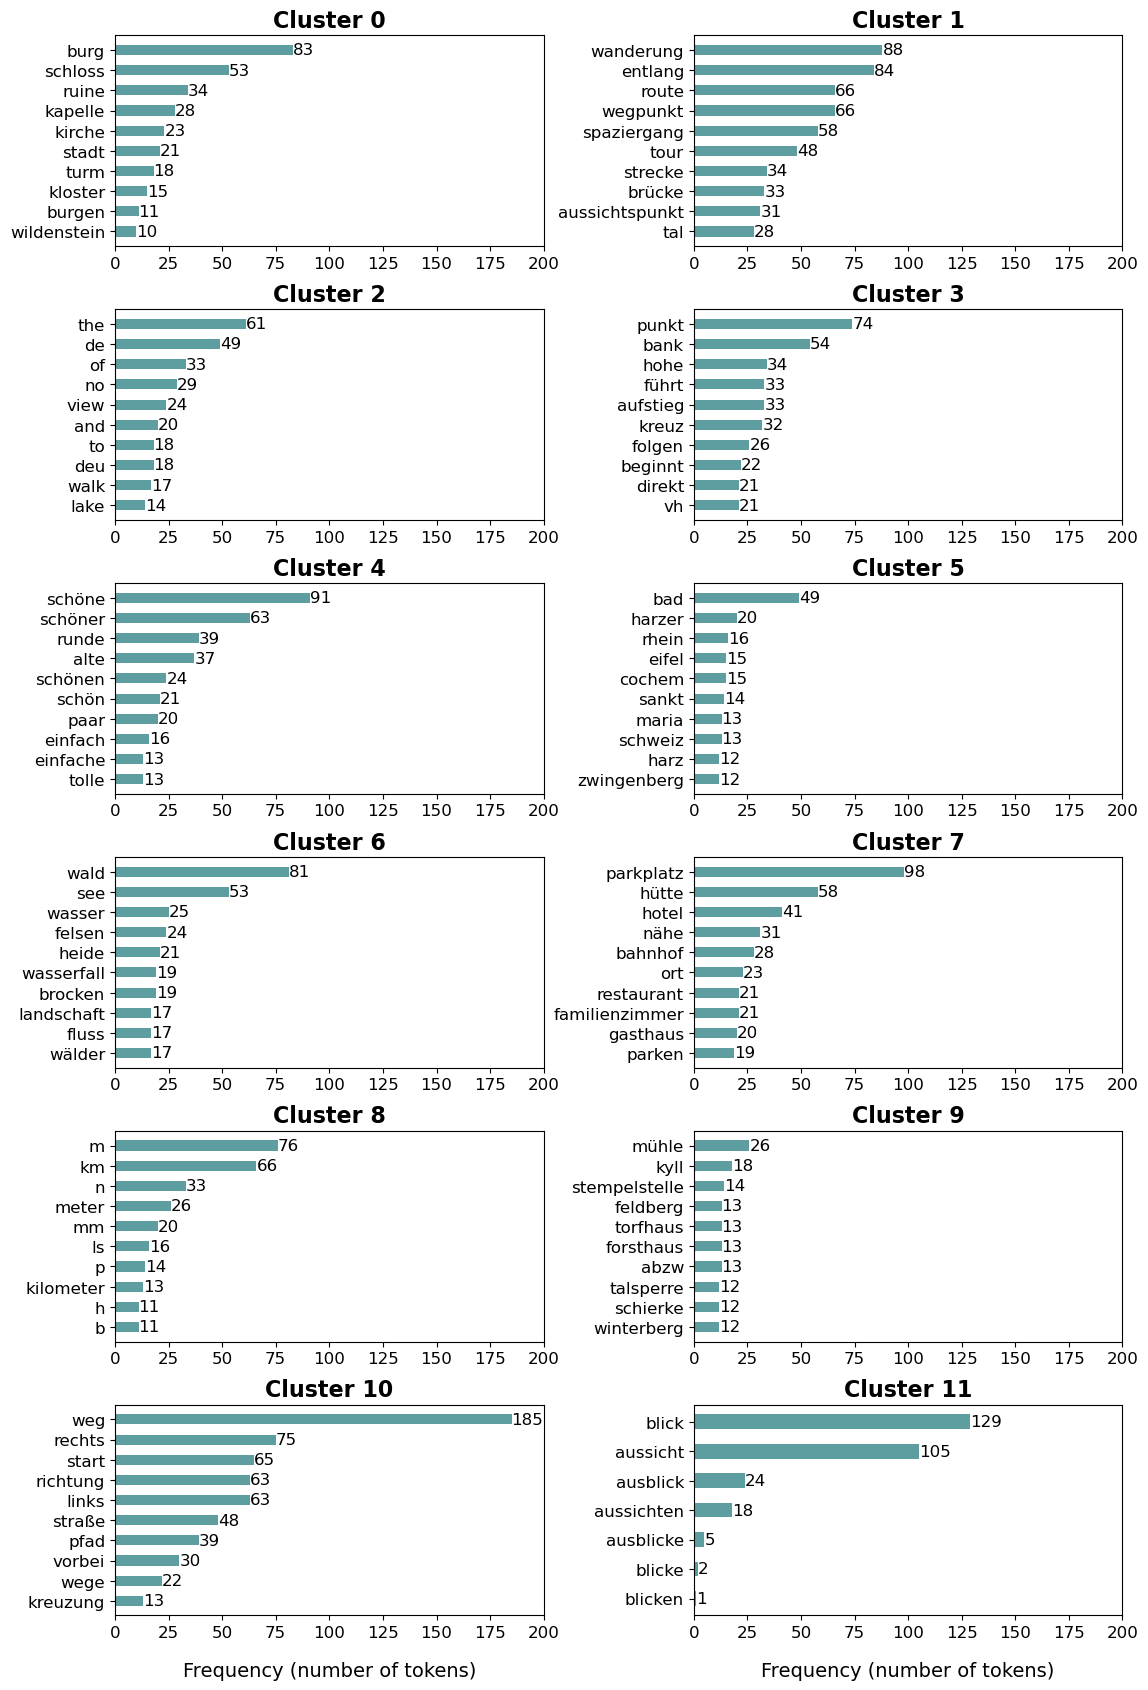

In [288]:
# STEP 6.4: CLUSTER MEMBERSHIP - TOKEN COMPARISON
# Create horizontal bar charts for individual token counts per cluster for each class

# Create a list of the dfs to plot 
top10_clus_tokens = [clus0_top10_df, clus1_top10_df, clus2_top10_df, clus3_top10_df,
                    clus4_top10_df, clus5_top10_df, clus6_top10_df, clus7_top10_df,
                    clus8_top10_df, clus9_top10_df, clus10_top10_df, clus11_top10_df]


# Create custom titles (UPDATE LATER)
all_titles = ["Cluster 0", "Cluster 1", 
              "Cluster 2",  "Cluster 3", 
              "Cluster 4", "Cluster 5", 
              "Cluster 6", "Cluster 7", 
              "Cluster 8", "Cluster 9",
              "Cluster 10", "Cluster 11"]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13,20))

# Allows to iterate in 1 dimension
axes = axes.flatten()

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
for i in range(12):
    bar_chart_c3 = axes[i].barh(top10_clus_tokens[i]["token"], 
                                   top10_clus_tokens[i]["count"],
                                   color = "CadetBlue",
                                   height = 0.5)
    axes[i].invert_yaxis()
    axes[i].set_title(all_titles[i], fontsize=16, fontweight="bold")
    axes[i].set_xlim(right=200)
    axes[i].bar_label(bar_chart_c3, fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[10].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)
    axes[11].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.35)

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_token_counts_per_cluster_overall.png', bbox_inches='tight')

# Show plot
plt.show()

Spatial representation of tokens

- using a list of tokens per cluster, link the tokens back to the trails
- if a token from a cluster is in the trail text then count that trail as being relevant to the cluster - this means trails will be counted towards multiple clusters
- once I have a list of the trails per cluster, I can use the trail URLs to link back to the geometries
- plot the geometries per cluster - make a set of mini maps for each cluster

In [ ]:
# STEP 6.4: LINK CLUSTER TOKENS TO TRAIL URLS 

# Create a function which extracts the unique tokens per cluster (and returns as df)
def token_extractor(df, clus_num):
    clus_tokens = df.loc[df["cluster"] == clus_num, "token"].tolist()
    clus_tokens_unq = list(set(clus_tokens))
    clus_tokens_unq_df = pd.DataFrame(clus_tokens_unq, columns=["token"])
    return clus_tokens_unq_df

# Use function to store tokens for each cluster
clus0_tokens = token_extractor(token_cluster_all, 0)
clus1_tokens = token_extractor(token_cluster_all, 1)
clus2_tokens = token_extractor(token_cluster_all, 2)
clus3_tokens = token_extractor(token_cluster_all, 3)
clus4_tokens = token_extractor(token_cluster_all, 4)
clus5_tokens = token_extractor(token_cluster_all, 5)
clus6_tokens = token_extractor(token_cluster_all, 6)
clus7_tokens = token_extractor(token_cluster_all, 7)
clus8_tokens = token_extractor(token_cluster_all, 8)
clus9_tokens = token_extractor(token_cluster_all, 9)
clus10_tokens = token_extractor(token_cluster_all, 10)
clus11_tokens = token_extractor(token_cluster_all, 11)

# Load the tokenised df (df of track urls for Natura trails and ALL tokens - not filtered)
tokenised_nat_df = pickle.load(open("./processing/tokenised_nat_df.p", "rb"))

# Create a function for matching token lists and extracting the url where matches occur
def url_for_matching_tokens(main_df, clus_df):
    # Create empty list for storing urls
    matching_urls = []

    # For each row (trail) in the master df of all tokens
    for i in range(len(main_df)):
        # Store the tokens for the row
        tokens = main_df.loc[i, "tokens"]
        # Store the url for the row
        url = main_df.loc[i, "url_track"]
        
        # For each token in the token list for the row
        for token in tokens:
            # If the lower case version of the token is in the cluster set then append it's associated url
            if token.lower() in set(clus_df["token"]):
                matching_urls.append(url)
                break  # Stop after first match (otherwise duplicate URLs are collected)

    return matching_urls

# Run the function for each cluster
clus0_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus0_tokens)
clus1_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus1_tokens)
clus2_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus2_tokens)
clus3_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus3_tokens)
clus4_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus4_tokens)
clus5_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus5_tokens)
clus6_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus6_tokens)
clus7_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus7_tokens)
clus8_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus8_tokens)
clus9_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus9_tokens)
clus10_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus10_tokens)
clus11_trail_urls = url_for_matching_tokens(tokenised_nat_df, clus11_tokens)


In [ ]:
# STEP 6.4: LINK CLUSTER TOKENS TO TRAIL URLS (TOP 10 VERSION)

# Extract df of top 10 tokens per cluster
clus0_top10tokens = top10_clus_tokens[0]["token"].to_frame()
clus1_top10tokens = top10_clus_tokens[1]["token"].to_frame()
clus2_top10tokens = top10_clus_tokens[2]["token"].to_frame()
clus3_top10tokens = top10_clus_tokens[3]["token"].to_frame()
clus4_top10tokens = top10_clus_tokens[4]["token"].to_frame()
clus5_top10tokens = top10_clus_tokens[5]["token"].to_frame()
clus6_top10tokens = top10_clus_tokens[6]["token"].to_frame()
clus7_top10tokens = top10_clus_tokens[7]["token"].to_frame()
clus8_top10tokens = top10_clus_tokens[8]["token"].to_frame()
clus9_top10tokens = top10_clus_tokens[9]["token"].to_frame()
clus10_top10tokens = top10_clus_tokens[10]["token"].to_frame()
clus11_top10tokens = top10_clus_tokens[11]["token"].to_frame()


# Load the tokenised df (df of track urls and ALL tokens - not filtered)
tokenised_df = pickle.load(open("./processing/tokenised_df.p", "rb"))

# Create a function for matching token lists and extracting the url where matches occur
def url_for_matching_tokens(main_df, clus_df):
    # Create empty list for storing urls
    matching_urls = []

    # For each row (trail) in the master df of all tokens
    for i in range(len(main_df)):
        # Store the tokens for the row
        tokens = main_df.loc[i, "tokens"]
        # Store the url for the row
        url = main_df.loc[i, "url_track"]
        
        # For each token in the token list for the row
        for token in tokens:
            # If the lower case version of the token is in the cluster set then append it's associated url
            if token.lower() in set(clus_df["token"]):
                matching_urls.append(url)
                break  # Stop after first match (otherwise duplicate URLs are collected)

    return matching_urls

# Run the function for each cluster
clus0_trail_urls = url_for_matching_tokens(tokenised_df, clus0_top10tokens)
clus1_trail_urls = url_for_matching_tokens(tokenised_df, clus1_top10tokens)
clus2_trail_urls = url_for_matching_tokens(tokenised_df, clus2_top10tokens)
clus3_trail_urls = url_for_matching_tokens(tokenised_df, clus3_top10tokens)
clus4_trail_urls = url_for_matching_tokens(tokenised_df, clus4_top10tokens)
clus5_trail_urls = url_for_matching_tokens(tokenised_df, clus5_top10tokens)
clus6_trail_urls = url_for_matching_tokens(tokenised_df, clus6_top10tokens)
clus7_trail_urls = url_for_matching_tokens(tokenised_df, clus7_top10tokens)
clus8_trail_urls = url_for_matching_tokens(tokenised_df, clus8_top10tokens)
clus9_trail_urls = url_for_matching_tokens(tokenised_df, clus9_top10tokens)
clus10_trail_urls = url_for_matching_tokens(tokenised_df, clus10_top10tokens)
clus11_trail_urls = url_for_matching_tokens(tokenised_df, clus11_top10tokens)



In [ ]:
# STEP 6.4: LINK CLUSTER URLS TO GEOMS

# Store the cluster trail urls in a dictionary (with names for file naming later)
clus_trail_main = {"clus0": clus0_trail_urls, "clus1": clus1_trail_urls, "clus2": clus2_trail_urls,
                   "clus3": clus3_trail_urls, "clus4": clus4_trail_urls, "clus5": clus5_trail_urls,
                   "clus6": clus6_trail_urls, "clus7": clus7_trail_urls, "clus8": clus8_trail_urls,
                   "clus9": clus9_trail_urls, "clus10": clus10_trail_urls, 
                   "clus11": clus11_trail_urls}

# Load the master GEOM shp (doesn't have all text but has URLs and geoms)
master_geoms_gdf = gpd.read_file("./processing/master_geoms_natura.shp")

# Create a function for joining the clus_urls with the master_geoms and returns centroids
def clus_trail_geoms(geom_gdf, cluster_dict):
    for name, url_list in cluster_dict.items():
        # Use name from dict for file naming
        output_path = "./processing/" + name + "_trails.shp"

        # Convert to df for merge
        url_df = pd.DataFrame(url_list, columns=["url_track"])

        # Left join so that only urls from the cluster trails remain
        clus_geom = pd.merge(url_df, geom_gdf, how="left", on="url_track")
        clus_geom_gdf = gpd.GeoDataFrame(clus_geom, geometry="geometry", crs=geom_gdf.crs)

        # Optional: Convert polygon geoms to centroids
        clus_geom_gdf["geometry"] = clus_geom_gdf.geometry.centroid
        
        # Save to shapefile
        clus_geom_gdf.to_file(output_path, driver="ESRI Shapefile")

# Run function to generate the shapefiles
clus_trail_geoms(master_geoms_gdf, clus_trail_main)

Resources for mapping:
- https://geopandas.org/en/stable/docs/user_guide/mapping.html
- https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html

C:\Users\ninam\AppData\Local\Temp\ipykernel_9632\1034405469.py:30: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  cluster_gdf.plot(ax=axes[i], marker='o', color='Red', markersize=2)


IndexError: list index out of range

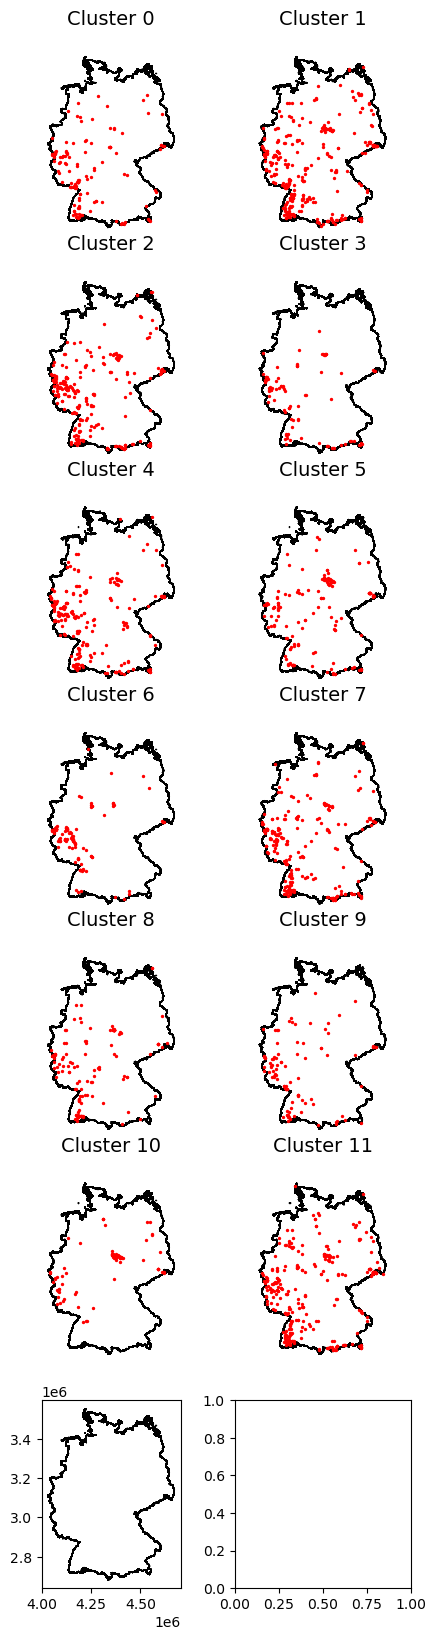

In [ ]:
# STEP 6.4: CREATE CLUSTER TRAIL MAPS

# Load Germany footprint to use outline as basemap
de_outline = gpd.read_file("./processing/clipper.shp")

# Store the cluster titles (UPDATE LATER)
all_titles = ["Cluster 0", "Cluster 1", 
              "Cluster 2",  "Cluster 3", 
              "Cluster 4", "Cluster 5", 
              "Cluster 6", "Cluster 7", 
              "Cluster 8", "Cluster 9",
              "Cluster 10", "Cluster 11"]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(5, 20))  

# Allows to iterate in 1 dimension
axes = axes.flatten() 

for i in range(12):
    # Load cluster trails as gdf after assembling path
    cluster_name = "clus" + str(i)
    cluster_path = "./processing/" + cluster_name + "_trails.shp"
    cluster_gdf = gpd.read_file(cluster_path)

    # Plot Germany outline
    de_outline.plot(ax=axes[i], color='white', edgecolor='black')

    # Plot cluster trail centroids
    cluster_gdf.plot(ax=axes[i], marker='o', color='Red', markersize=2)

    # OR Plot cluster trail polygons
    #cluster_gdf.plot(ax=axes[i], color="Red", edgecolor="Red")

    # Add title and remove x,y axis
    axes[i].set_title(all_titles[i], fontsize=14)
    axes[i].set_axis_off()

    # Add scale bar and north arrow for the first plot
    axes[1].add_artist(ScaleBar(distance_meters))

plt.subplots_adjust(hspace=0.2, wspace=0.1)

# Tight layout and display
plt.tight_layout()
plt.show()